In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import os
import numpy as np

In [ ]:
plots_dir = '/home/juliame/metaphor/results/plots_dec2024/'

In [38]:
def load_data(data_dir,filename):
    full_path = os.path.join(data_dir,filename)
    df = pd.read_csv(full_path,sep='\t')
    score_cols = [c for c in df.columns if c.startswith('score_')]
    concepts = [c.replace('score_','') for c in score_cols]
    df['date'] = pd.to_datetime(df[['year','month']].assign(day=1))
    df.loc[df['date'] == pd.to_datetime('2020-01-01'),'date'] = pd.to_datetime('2019-12-01') # account for timezone issue
    df.loc[df['date'] == pd.to_datetime('2023-06-01'),'date'] = pd.to_datetime('2023-05-01') # account for timezone issue

    df['ideology_bin'] = df['ideology'].apply(lambda x: 'liberal' if x <= 0 else 'conservative')
    df = df[['date','ideology_bin','ideology']+score_cols]
    df.columns = [c.replace('score_','') for c in df.columns]
    return df

In [39]:
orig_data_dir = '/nfs/turbo/si-juliame/metaphor/results/full_datasheets/2024-10-07/' #2018-2019
new_data_dir = '/nfs/turbo/si-juliame/metaphor/results/full_datasheets/2021-2023/' #2021-2023
filename = 'filtered_tweet_data_shuffled_no_text_results_with_scores.tsv'
df_orig = load_data(orig_data_dir,filename)
df_new = load_data(new_data_dir,filename)


In [3]:
data_dir = '/nfs/turbo/si-juliame/metaphor/results/full_datasheets/2024-10-07/'
filename = os.path.join(data_dir,'filtered_tweet_data_shuffled_no_text_results_with_scores.tsv')
df = pd.read_csv(filename,sep='\t')

In [79]:
score_cols = [c for c in df.columns if c.startswith('score_')]
concepts = [c.replace('score_','') for c in score_cols]

In [80]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.loc[df['date'] == pd.to_datetime('2020-01-01'), 'date'] = pd.to_datetime('2019-12-01')

In [81]:
df['ideology_bin'] = df['ideology'].apply(lambda x: 'liberal' if x <= 0 else 'conservative')

In [82]:
df_sub = df[['date','ideology_bin','ideology']+score_cols]
df_sub.columns = [c.replace('score_','') for c in df_sub.columns]

In [83]:
df_percent_diff = df_sub.groupby(by='ideology_bin').agg('mean')[concepts].transpose()

In [84]:
df_percent_diff['percent_diff'] = 100 * (df_percent_diff['conservative'] - df_percent_diff['liberal']) / df_percent_diff['liberal']

In [ ]:
df_sub_long = pd.melt(df_sub,id_vars=['date','ideology_bin','ideology'])
df_sub_long.columns = ['date','ideology_bin','ideology','concept','score']
df_sub_long

In [90]:
df_to_plot = df_sub_long[df_sub_long['concept'] != 'overall']

In [91]:
df_to_plot_sample = df_to_plot.sample(n=4000)

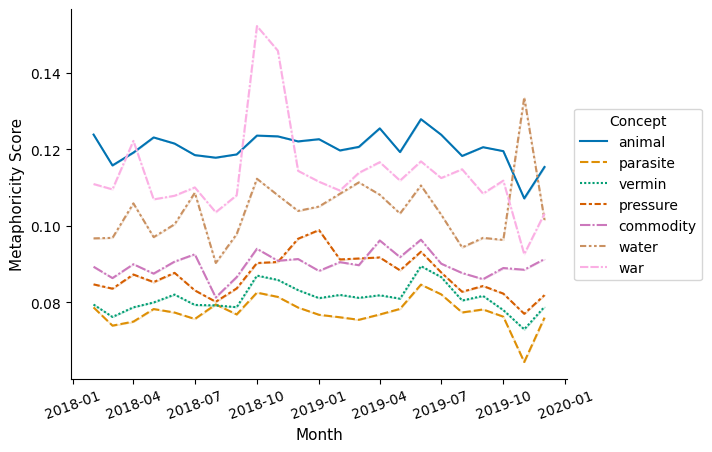

In [134]:
sns.lineplot(x='date',y='score',hue='concept',palette='colorblind',data=df_to_plot,errorbar=('ci', False),style='concept')
sns.despine()
plt.legend(title='Concept',bbox_to_anchor=(1,.75))
plt.xticks(rotation=20)
plt.xlabel('Month',fontsize=11)
plt.ylabel('Metaphoricity Score',fontsize=11)
plt.savefig(os.path.join(plots_dir,'score_by_month.pdf'),bbox_inches='tight')

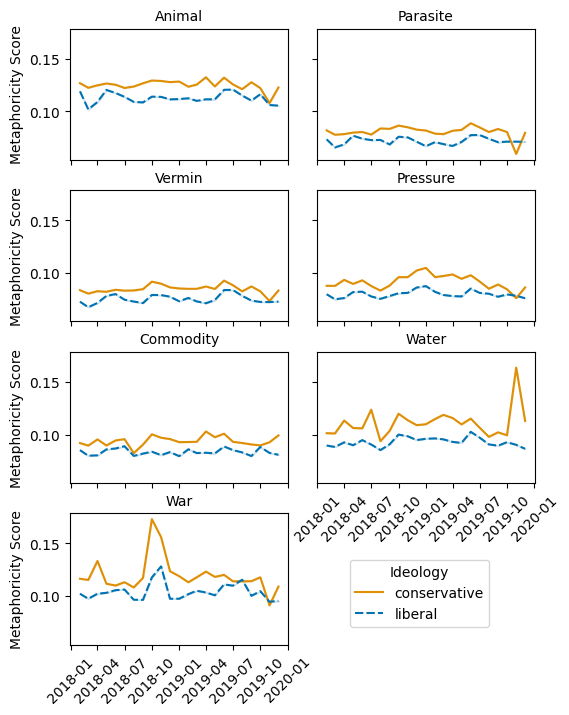

In [178]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 8),sharey=True,sharex='col')
axes_flat = axes.flatten()

color_palette = sns.color_palette('colorblind')[:2][::-1]

for i,concept in enumerate(concepts):
    if concept != 'overall':
        df_concept = df_to_plot[df_to_plot['concept']==concept]
        sns.lineplot(x='date',y='score',hue='ideology_bin', style = 'ideology_bin',
                     palette=color_palette,data=df_concept,errorbar=('ci', False),ax=axes_flat[i],
                    legend=True)
        axes_flat[i].set_ylabel('Metaphoricity Score')
        axes_flat[i].set_xlabel('')
        axes_flat[i].set_title(concept.title(),fontsize=10)
        if i >= 5:
            axes_flat[i].tick_params(axis='x', rotation=45,labelbottom=True)
        else:
            axes_flat[i].tick_params(axis='x', rotation=45,labelbottom=False)
        if i < 6:
            axes_flat[i].get_legend().remove()
axes_flat[len(concepts)-1].set_visible(False)

handles, labels = axes_flat[6].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.05), title='Ideology')
axes_flat[6].legend(title='Ideology',bbox_to_anchor=(1.25,.7))

plt.subplots_adjust(wspace = 0.13,hspace=0.23)
plt.savefig(os.path.join(plots_dir,'scores_by_ideology_over_time.pdf'),bbox_inches='tight')

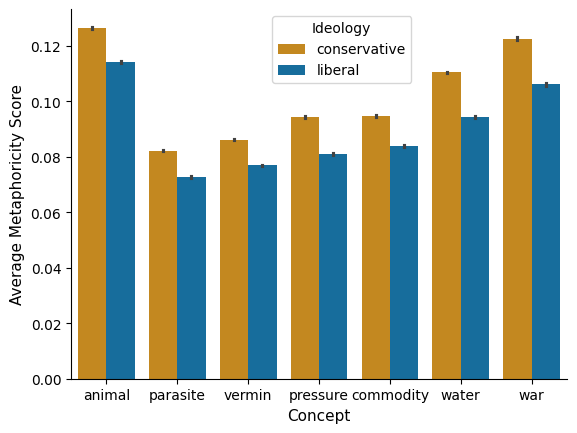

In [180]:
color_palette = sns.color_palette('colorblind')[:2][::-1]
sns.barplot(x='concept',y='score',hue='ideology_bin',data=df_to_plot,palette=color_palette)
sns.despine()
plt.legend(title='Ideology',bbox_to_anchor=(.7,1))
plt.xlabel('Concept',fontsize=11)
plt.ylabel('Average Metaphoricity Score',fontsize=11)
plt.savefig(os.path.join(plots_dir,'average_scores_by_ideology.pdf'),bbox_inches='tight')

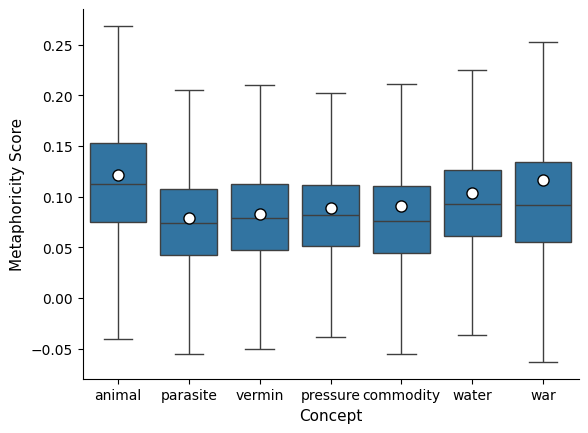

In [190]:
sns.boxplot(x='concept',y='score',data=df_to_plot,showfliers=False,showmeans=True,
           meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})
sns.despine()
plt.ylabel('Metaphoricity Score',fontsize=11)
plt.xlabel('Concept',fontsize=11)
plt.savefig(os.path.join(plots_dir,'score_boxplot.pdf'),bbox_inches='tight')